# PyNEST - Spatial Networks

**Modeling networks of spiking neurons with modular connectivity using NEST**

**CNS 2021, 03.07.2021**

**[Jasper Albers](mailto:j.albers@fz-juelich.de), [Barna Zajzon](mailto:b.zajzon@fz-juelich.de)**

<table><tr>
<td> 
    <div style="text-align:center">
        <img src="img/fig_modular_full.jpg" alt="modular connectivity" width="1000" align="left"/> <br />
    Sequentially connected spiking networks with modular feed-forward connectivity </div>
</td>
   
    
</tr></table>

___
## Setup

In [1]:
import copy
import matplotlib.pyplot as plt
# %matplotlib notebook
# import NEST & NEST rasterplot
import nest
import nest.raster_plot
import numpy as np
from modularity import modular_matrix, print_weight_matrix, get_all_clusters

Generating modular connectivity matrices, with parameter **m**:

\begin{align}
m = 1 - \frac{p_\mathrm{out}}{p_\mathrm{in}} \\
\end{align}
where $p_\mathrm{in}$ is the connection probability for neurons within the same cluster, and $p_\mathrm{out}$ for neurons belonging to different clusters. These are chosen such that the overall connection density remains unchanged.

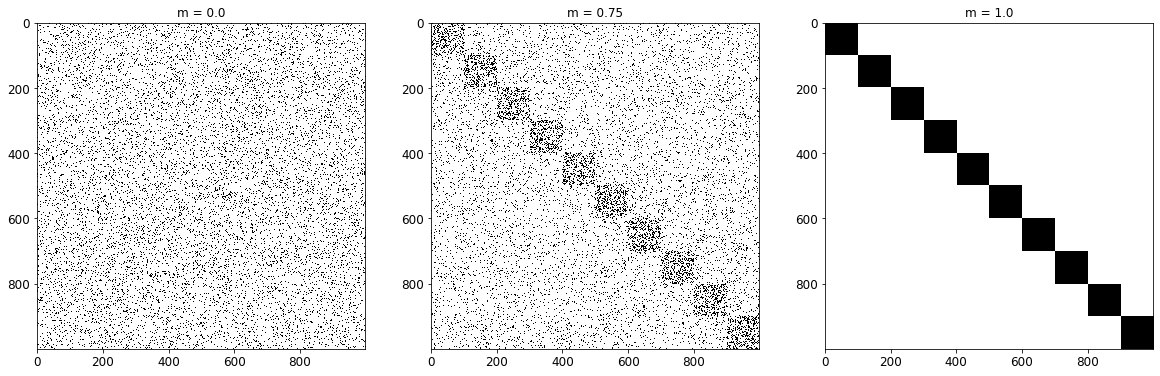

In [2]:
n_cluster = 10
N = 1000
density = 0.1
m = [0., 0.75, 1.]

fig, ax = plt.subplots(1, len(m), figsize=(20, 6))

for idx, mod in enumerate(m):
    A = modular_matrix(layer=0, N=N, src_neurons=N, tgt_neurons=N, n_clusters=n_cluster, 
                       density=density, modularity=mod)
    print_weight_matrix(A, label="m = {}".format(mod), ax=ax[idx])

plt.show()


#### Simulation parameters and NEST initialization

In [3]:
# simulation parameters
simtime = 2000.  # simulation time (ms)
dt = 0.1  # simulation resolution (ms)

# configure kernel
nest.ResetKernel()
nest.SetKernelStatus({
    'resolution': dt,      # set simulation resolution
    'local_num_threads': 6 # use two threads to build & simulate the network
})

#### Model parameters

In [4]:
# network parameters
gamma = 0.25          # relative number of inhibitory connections
N = 5000
NE = int(0.8 * N)     # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)  # number of inhibitory neurons
N_rec = 1000          # record from 100 (50 e + 50 i) neurons
CE = int(NE * 0.1)    # indegree from excitatory neurons
CI = int(gamma * CE)  # indegree from inhibitory neurons

# layer parameters
n_layers = 5
ff_density = 0.075  # density of feed-forward connectivity matrix
modularity = 0.9    # feed-forward modularity

# synapse parameters
w = 32.28 * 1.2     # excitatory synaptic weight (mV)
g = 12.             # relative inhibitory to excitatory synaptic weight
d = 1.5             # synaptic transmission delay (ms)

# neuron paramters
V_th = -55.  # spike threshold (mV)
E_L = -70.   # resting membrane potential (mV)
tau_m = 20.  # membrane time constant (ms)
neuron_params = {
    'C_m': 250.0,     # membrane capacity (pF)
    'E_L': E_L,       # resting membrane potential (mV)
    'I_e': 0.,        # external input current (pA)
    'V_m': -70.,      # membrane potential (mV)
    'V_reset': -70.,  # reset membrane potential after a spike (mV)
    'V_th': V_th,     #
    't_ref': 2.0,     # refractory period (ms)
    'tau_m': tau_m,   #
}

# external input parameters
nu_ex = 12.                                    # baseline input (spikes/s)

#### Create layers

In [5]:
# synapse specification
syn_exc = {'delay': d, 'weight': w}
syn_inh = {'delay': d, 'weight': - g * w}

# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_exp', neuron_params)

# create layers of E and I populations
layers = {'E': [], 'I': []}

for l in range(n_layers):
    # create populations and randomize initial Vm values
    layers['E'].append(nest.Create('iaf_psc_exp', NE, {'V_m': nest.random.uniform(min=E_L, max=V_th)}))
    layers['I'].append(nest.Create('iaf_psc_exp', NI, {'V_m': nest.random.uniform(min=E_L, max=V_th)}))

#### Connect layers sequentially

In [6]:
# create modular feed-forward connection matrices and connect layers
for l in range(n_layers - 1):
    A_exc = modular_matrix(layer=l, N=N, src_neurons=NE, tgt_neurons=NE,
                           n_clusters=n_cluster, density=ff_density, modularity=modularity)
    A_inh = modular_matrix(layer=l, N=N, src_neurons=NE, tgt_neurons=NI,
                           n_clusters=n_cluster, density=ff_density, modularity=modularity)

    # concatenate E->E and E->I matrices for speedup
    A_full = np.concatenate((A_exc, A_inh), axis=1)
    
    # to create connections based on a weight/adjacency matrix (pre X post), 
    # just iterate the pre-synaptic neurons and connect one row at a time
    for i, pre in enumerate(layers['E'][l]):
        layer_e_next = layers['E'][l+1]
        layer_i_next = layers['I'][l+1]

        tgt_j = A_exc[i, :].nonzero()[0]
        post_nodes = layer_e_next[tgt_j]
        nest.Connect(pre, post_nodes, syn_spec=syn_exc)

        tgt_j = A_inh[i, :].nonzero()[0]
        post_nodes = layer_i_next[tgt_j]
        nest.Connect(pre, post_nodes, syn_spec=syn_exc)

# get NodeCollections for all clusters in each layer 
# in the form: {'E': [..], 'I': [..]}
clusters = get_all_clusters(n_layers, n_cluster, N, NE, NI)

#### Recurrent connections

In [7]:
# recurrent connection specification (fixed indegrees)
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}

for l in range(n_layers):
    l_e = layers['E'][l]
    l_i = layers['I'][l]

    nest.Connect(l_e, l_e, conn_exc, syn_exc)
    nest.Connect(l_e, l_i, conn_exc, syn_exc)
    nest.Connect(l_i, l_e, conn_inh, syn_inh)
    nest.Connect(l_i, l_i, conn_inh, syn_inh)

#### Background input

In [8]:
# background input parameters
noise_scale_deep = 0.4                         # reduce noise in the deeper layers
p_rate_bg_inp = CE * nu_ex                     # rate of background input in input layer (L1)
p_rate_bg_deep = CE * nu_ex * noise_scale_deep # rate of background input in deeper layers (L > 1)

# create poisson generators for background input (inp and deep)
pgen_bg_inp = nest.Create('poisson_generator', params={'rate': p_rate_bg_inp})
pgen_bg_deep = nest.Create('poisson_generator', params={'rate': p_rate_bg_deep})

# connect background input using the excitatory connection weight
for l in range(n_layers):
    for pop in ['E', 'I']:
        if l == 0:
            nest.Connect(pgen_bg_inp, layers[pop][l], syn_spec=syn_exc)
        else:
            nest.Connect(pgen_bg_deep, layers[pop][l], syn_spec=syn_exc)

#### Stimulus input

In [9]:
# create stimulus input: 200 ms pulses (step signal) at various times
stim_scaling = 0.15                        # scale stimulus input
p_rate_stim1 = CE * nu_ex * stim_scaling  # rate of stimulus input (spikes/s)
p_rate_stim2 = p_rate_stim1 * 1.         # we can vary the relative stimulus intensities

# we use 2 `inhomogeneous_poisson_generator` devices, and set their rate 
# to `p_rate_stim` for 200 ms at various times
pgen_stim1 = nest.Create('inhomogeneous_poisson_generator', 
                         params={'rate_times': [400., 600., 1600.],
                                 'rate_values': [p_rate_stim1, 0., p_rate_stim1]})
pgen_stim2 = nest.Create('inhomogeneous_poisson_generator',
                         params={'rate_times': [800., 1000., 1600.],
                                 'rate_values': [p_rate_stim2, 0., p_rate_stim2]})

# connect stimulus to the first cluster in L1 using the excitatory connection weight
nest.Connect(pgen_stim1, clusters['E'][0][0], syn_spec=syn_exc)
nest.Connect(pgen_stim1, clusters['I'][0][0], syn_spec=syn_exc)
nest.Connect(pgen_stim2, clusters['E'][0][-1], syn_spec=syn_exc)
nest.Connect(pgen_stim2, clusters['I'][0][-1], syn_spec=syn_exc)


#### Create and connect recording devices

In [10]:
# create spike detectors
spkrec_layers_e = [nest.Create('spike_recorder') for _ in range(n_layers)]
spkrec_cluster1_e = [nest.Create('spike_recorder') for _ in range(n_layers)]

# connect N_rec excitatory
ids_to_rec = np.random.choice(np.arange(1, NE), size=N_rec, replace=False)
for idx in range(n_layers):
    subset = np.zeros(NE).astype(bool)
    subset[ids_to_rec] = True
    nest.Connect(layers['E'][idx][subset], spkrec_layers_e[idx])
    nest.Connect(clusters['E'][idx][0], spkrec_cluster1_e[idx])

#### Run simulation and plot activity

Firing rates (layer, cluster)
Layer 0: 5.4845	6.78125
Layer 1: 3.8765	5.4037500000000005
Layer 2: 3.276	5.09375
Layer 3: 3.114	5.3149999999999995
Layer 4: 3.124	6.041250000000001


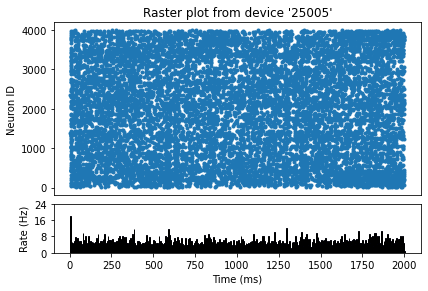

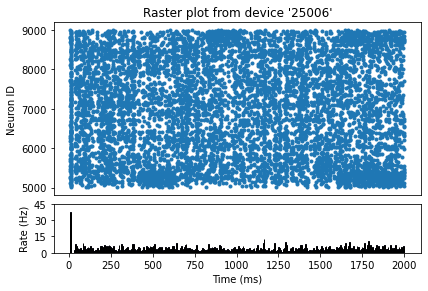

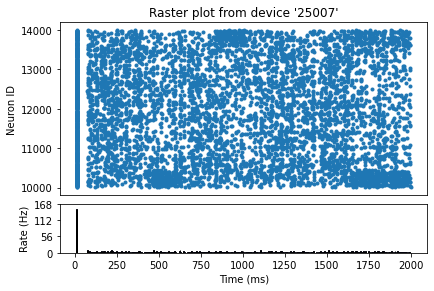

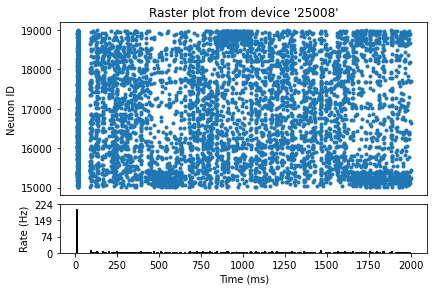

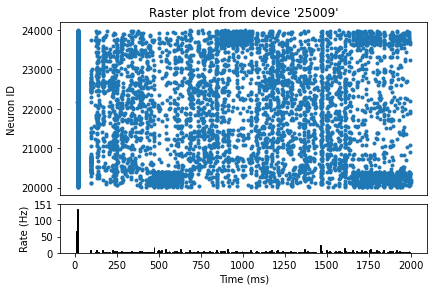

In [11]:
# simulate
nest.Simulate(simtime)
cluster_size_e = len(clusters['E'][idx][0])  # size of an excitatory cluster

print("Firing rates (layer, cluster)")
for l in range(n_layers):
    rate_l_ex = spkrec_layers_e[l].get('n_events') / simtime / N_rec * 1e3
    rate_cl_ex = spkrec_cluster1_e[l].get('n_events') / simtime / cluster_size_e * 1e3
    print("Layer {}: {}\t{}".format(l, rate_l_ex, rate_cl_ex))

    nest.raster_plot.from_device(spkrec_layers_e[l], hist=True)
plt.show()

#### If you'd like to know more about stimulus denoising through modular topography, drop by at poster P48.